In [78]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gudhi
from libs.XY_model import XYSystem
from tqdm import tqdm
from numba import jit

In [79]:
def number_of_b0_b1(p):
    rips = gudhi.RipsComplex(points = p, max_edge_length = 1.5)
    s_tree = rips.create_simplex_tree(max_dimension = 2)
    diag = s_tree.persistence()
    b0, b1 = 0, 0
    for dg in diag:
        if(dg[1][1] > 1.42):
            if(dg[0] == 0):
                b0 += 1
            if(dg[0] == 1):
                b1 += 1
    return b0, b1, diag

In [80]:
@jit(forceobj=True)
def image_to_point(X):
    points = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if(X[i, j] != 255):
                a = np.array([i, j])
                points.append(a)
    points = np.array(points)
    return points

In [81]:
def local_merging_number(X, patches_x, patches_y, step_perc = 0.5, thresh = 1):
    x_b0, x_b1, dg = number_of_b0_b1(image_to_point(X))

    px_s = (int)(X.shape[0] / patches_x) 
    py_s = (int)(X.shape[1] / patches_y)
    while((X.shape[0] - patches_x * px_s) >= px_s):
      px_s += 1
    while((X.shape[1] - patches_y * py_s) >= py_s):
      py_s += 1
    print(f"{X.shape}, px_s = {px_s}, py_s = {py_s}")
    
    
    Y = np.zeros([X.shape[0], X.shape[1]]) + 255

    offset = 0
    
    lg = np.zeros([patches_x, patches_y])
    olg = np.zeros([patches_x, patches_y])

    step_x = (int)(step_perc * px_s)
    step_y = (int)(step_perc *py_s)
    i, j = 0, 0
    pbar = tqdm(total = X.shape[0] - px_s)
    while(i < (X.shape[0] - px_s)):
      while(j < (X.shape[1] - py_s)):
        X1 = np.zeros([X.shape[0], X.shape[1]]) + 255
        X2 = np.zeros([X.shape[0], X.shape[1]]) + 255
        # print(f"({i + 1} : {i + px_s}), ({j + 1} : {j + py_s}), {offset}")
        X1[ (i + 1) : (i + step_x), (j + 1) : (j + py_s) ] = np.array(X[(i + 1) : (i + step_x), (j + 1) : (j + py_s)])
        x1_b0, x1_b1, dg = number_of_b0_b1(image_to_point(X1[(i + 1) : (i + step_x), (j + 1) : (j + py_s)]))

        X2 = np.array(X)
        X2[ i : (i + px_s - 1), j : (j + py_s - 1)] = 255
        x2_b0, x2_b1, dg = number_of_b0_b1(image_to_point(X2))

        if((x1_b1 != 0) or (x2_b1 < x_b1)):
          n = (int) (i/px_s)
          m = (int) (j/py_s)
          olg[n, m] += (x1_b1 + x2_b1)
          Y[i : (i + px_s - 1), j : (j + py_s - 1) ] = np.array(X[i : (i + px_s - 1), j : (j + py_s - 1) ])

        offset+=1
        j += step_y
      j = 0
      i += step_x
      pbar.update(step_x)
    pbar.close()
    return olg, Y

In [82]:
def generate_xy_configs(temp, N = 16):
    xy_config = np.zeros([N, N, temp.shape[0]])

    for i in range(temp.shape[0]):
        xy = XYSystem(temperature=temp[i], width=N)
        xy.equilibrate(show=False)
        xy.show()
        xy_config[:, :, i] = np.reshape(xy.spin_config, (-1, N))
    return xy_config


equilibrium state is reached at T=0.2
#sweep=513
energy=-1.86


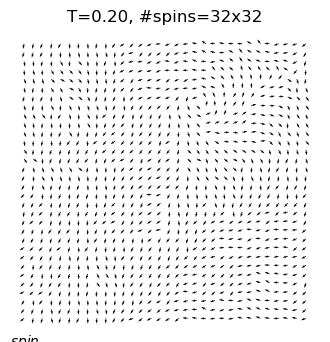


equilibrium state is reached at T=0.4
#sweep=562
energy=-1.76


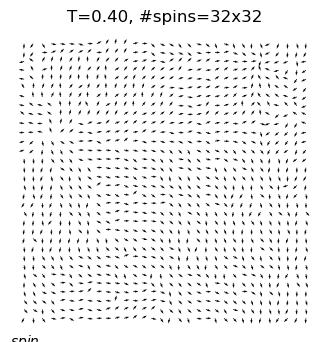

KeyboardInterrupt: 

In [100]:
N = 32
T = np.array([0.2, 0.4, 0.6, 0.9, 1.1, 1.3])
XY = generate_xy_configs(T, N)

In [ ]:
thresh = 0.5
img = np.zeros([N, N, T.shape[0]])
for t in tqdm(range(T.shape[0])):
    for i in range(N):
        for j in range(N):
            if(abs(XY[i, j, t] - XY[(i + 1)%N, j, t]) <= thresh):
                img[i, j, t] = 0
            else:
                img[i, j, t] = 255

100%|██████████| 3/3 [00:00<00:00, 266.02it/s]


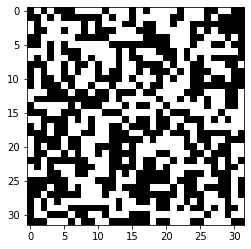

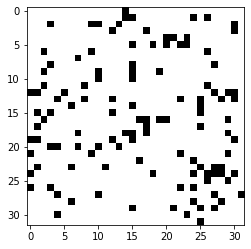

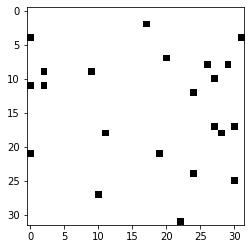

In [ ]:
org_map = plt.cm.get_cmap('Greys')
rev_map = org_map.reversed()

for t in range(T.shape[0]):
    plt.imshow(img[:, :, t], cmap=rev_map)
    plt.show()
    plt.close();

In [86]:
# OLG = np.zeros([12, 12, T.shape[0]])
# Map = np.zeros([N, N, T.shape[0]])

In [87]:
OLG, Map = local_merging_number(img[:, :, 0], 10, 10, 0.3)

(32, 32), px_s = 3, py_s = 3


  0%|          | 0/29 [00:00<?, ?it/s]

KeyboardInterrupt: 

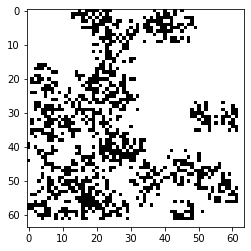

In [ ]:
plt.imshow(Map, cmap=rev_map)

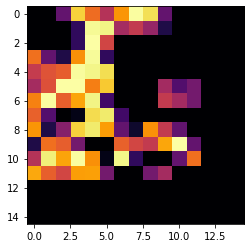

In [ ]:
plt.imshow(OLG, cmap='inferno')

In [ ]:
# for t in range(T.shape[0]):
#     plt.imshow(Map[:, :, t], cmap=rev_map)
#     plt.show()
#     plt.close();